# Анализ бизнес-показателей развлекательного приложения Procrastinate Pro+

Объект и цель исследования: Несмотря на огромные вложения в рекламу, последние несколько месяцев компания- разработчик развлекательного приложения терпит убытки. Наша задача — разобраться в причинах и помочь компании выйти в плюс.

План исследования:
1. [Ознакомление с данными и предобработка](#start)
    - [Изучение общей информации о датасете](#1.1)
    - [Приведение к змеиному регистру](#1.2)
    - [Изменение типов данных](#1.3)
    - [Поиск дубликатов и пропусков](#1.4)
    
2. [Загрузка функций](#preprocessing) 
    
    
3. [Исследовательский анализ данных](#analitic)
   - [Создание профилей пользователей ](#3.1) 
   - [Страны пользователей](#3.2)
   - [Устройства пользователей](#3.3)
   - [Рекламные источники](#3.4)
   - [Вывод по разделу](#3.5)
  
4. [Маркетинг](#marketing)
   - [Общая сумма расходов](#4.1)
   - [Траты по рекламным источникам](#4.2)
   - [Динамика изменения расходов во времени](#4.3)
   - [Расчет САС по источникам](#4.4)
   - [Вывод по разделу](#4.5)
   
5. [Оценка окупаемости рекламы](#roi)
   - [Анализ окупаемости рекламы](#5.1)
   - [Конверсия](#5.2)
   - [Удержание](#5.3)
   - [Окупаемость рекламы с разбивкой по устройствам](#5.4)
   - [Окупаемость рекламы с разбивкой по странам](#5.5)
   - [Окупаемость рекламы с разбивкой по рекламным каналам](#5.6)
   
6. [Оценка окупаемости рекламы в каджой стране](#roi_region)
   - [Анализ окупаемости рекламы в США](#6.1)
   - [Анализ окупаемости рекламы во Франции](#6.2)
   - [Анализ окупаемости рекламы в Германии](#6.3)
   - [Анализ окупаемости рекламы в Великобритании](#6.4)
   - [Вывод по разделу](#6.5)
   
7. [Вывод](#conclusion)  



<a id="start"></a>
### Загрузите данные и подготовьте их к анализу

Загрузим необходиме библиотеки и данные из файлов.


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns



In [2]:
visits = pd.read_csv('/datasets/visits_info_short.csv') #хранит лог сервера с информацией о посещениях сайта,
orders = pd.read_csv('/datasets/orders_info_short.csv') #информация о заказах
costs = pd.read_csv('/datasets/costs_info_short.csv') #информация о расходах на рекламу


Посмотрим общую информацию о датасетах.
Для анализа у нас есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
лог сервера с данными об их посещениях (visits),
выгрузка их покупок за этот период (orders),
рекламные расходы (costs).

In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [5]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


<a id="1.2"></a>
Мы видим, что у нас в данных нет пропусков. Для дальнейшей работы с данными приведем названия столбцов к "змеиному регистру". 

In [6]:
visits.columns = [x.lower().replace(' ', '_') for x in visits.columns.values]
orders.columns = [x.lower().replace(' ', '_') for x in orders.columns.values]
costs.columns = [x.lower().replace(' ', '_') for x in costs.columns.values]

<a id="1.3"></a>
Посмотрим на соответствие типов данных. Столбцы с датой и временем приведем к формату datetime, а с датой к фомату date. Вс остальные форматы данных соответствуют типу данных.

In [7]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

<a id="1.3"></a>
Проверим датасеты на явные дубликаты

In [8]:
visits.duplicated().sum()

0

In [9]:
orders.duplicated().sum()

0

In [10]:
costs.duplicated().sum()

0

Явных дубликатов нет. Попробуем поискать неявные дубликаты, посмотрим какие уникальные значения хранят столбцы, в которых они могут возникнуть.

In [11]:
visits['region'].unique()

array(['United States', 'UK', 'France', 'Germany'], dtype=object)

In [12]:
visits['device'].unique()

array(['iPhone', 'Mac', 'Android', 'PC'], dtype=object)

In [13]:
visits['channel'].unique()

array(['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

In [14]:
costs['channel'].unique()

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

Неявных дубликатов тоже не наблюдается.

In [15]:
visits.describe()

,user_id
count,3.099010e+05
mean,4.997664e+11
std,2.887899e+11
min,5.993260e+05
25%,2.493691e+11
50%,4.989906e+11
75%,7.495211e+11
max,9.999996e+11


С данными в user_id все в порядке.

In [16]:
orders.describe()

,user_id,revenue
count,4.021200e+04,40212.000000
mean,4.990295e+11,5.370608
std,2.860937e+11,3.454208
min,5.993260e+05,4.990000
25%,2.511324e+11,4.990000
50%,4.982840e+11,4.990000
75%,7.433327e+11,4.990000
max,9.998954e+11,49.990000


Подавляющее большинство платежей на сумму 4.99, сокрее всего это стандартная плата за пользование приложением.  Максимальный платеж на сумму 49.99 .Медиана и среднее близкие по значению, что говорит об отсутсвии сильных выбрососов в данных.

In [17]:
costs.describe()

,costs
count,1800.000000
mean,58.609611
std,107.740223
min,0.800000
25%,6.495000
50%,12.285000
75%,33.600000
max,630.000000


В расходах на рекламные кампании есть большой разброс. Среднее боьше медианы на 46,3. Стандартное отклонение равно 107,7. Самая дешевая рекламная кампания обошлась в 0.8, а дорогая в 630. Болле 75% всех рекламных кампаний приходятся на суммму до 33,6.

Проверим сколько по времени длились сессии, нет ли в них аномалий. Для этого посчитаем длительность сессий и посмотрим на их статистические показатели.

In [18]:
duration = ((visits['session_end'] - visits['session_start']) / np.timedelta64(1,'m')).round()#посчитали длительности сессии в минутах
duration.describe()


count    309901.000000
mean         29.999797
std          30.053643
min           0.000000
25%           9.000000
50%          21.000000
75%          42.000000
max         371.000000
dtype: float64

В основном сессии длились от 0 до 42 минут. Медианная продолжительность сессии - 21 минута. Среднее около 30 минут.

Мы ознакомились с данным о визитах, заказах и рекламных расходах приложения. Выполнили предобработку, выяснили, что в данных нет пропусков и дубликатов, привели столбцы к змеиному регистру и изменили типы данных в столбцах с датой и временем.

<a id="preprocessing"></a> 
### Задайте функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Для анализа биснес-показателей мы будем использовать следующие функции вычисления значений метрик:


- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [19]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    
    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


In [20]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [21]:

# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [22]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [23]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [24]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [25]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [26]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

<a id="analitic"></a> 
### Исследовательский анализ данных

- Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулируйте выводы.

<a id="3.1"></a>
Создадим профили пользователей используя функцию get_profiles(). Посмотрим на полученную таблицу с информацией о пользователях.

In [27]:
profiles = get_profiles(visits, orders,costs)
profiles.head(10)


,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
5,34186288,2019-05-09 17:29:23,organic,Android,United States,2019-05-09,2019-05-01,False,0.000000
6,38448301,2019-08-16 11:56:00,organic,Android,United States,2019-08-16,2019-08-01,False,0.000000
7,46006712,2019-06-30 03:46:29,AdNonSense,Android,France,2019-06-30,2019-06-01,True,1.008000
8,58263264,2019-05-11 19:18:43,FaceBoom,iPhone,United States,2019-05-11,2019-05-01,False,1.128205
9,59835779,2019-05-11 21:13:47,MediaTornado,iPhone,United States,2019-05-11,2019-05-01,False,0.250435


Определим максимальную и минимальную даты привлечения пользователей.

In [28]:
max_acquisition_date = profiles.reset_index()['dt'].max()
max_acquisition_date


datetime.date(2019, 10, 27)

In [29]:
min_acquisition_date = profiles.reset_index()['dt'].min()
min_acquisition_date

datetime.date(2019, 5, 1)

Итого минимальная дата привлечения пользователей 1 мая 2019 года, максимальная - 27 октября 2019 года, что соответсвует данным, указанным в ТЗ.

<a id="3.2"></a>
Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.
Для этого сгруппируем датасет с профилями пользователей по столбцу Регион, и вычислим количество уникальных пользователей по регионам, а также количество и среднее значение платящих пользователей.

In [30]:
profiles_region = profiles.groupby('region').agg({'user_id': 'nunique', 'payer': ['sum', 'mean']}) #сгруппируем профили по региону, найдем количество уникальных пользователй и количество и среднее платящих пользователей
profiles_region.columns=['_'.join(col).rstrip() for col in profiles_region.columns.values] #избавимся от мультииндексов
profiles_region = profiles_region.style.format({'payer_mean': '{:.2%}'})
profiles_region
#profiles_region.sort_values(by = 'payer_mean', ascending = False)  #отсортируем таблицу по количеству уникальных пользователей


,user_id_nunique,payer_sum,payer_mean
region,,,
France,17450,663,3.80%
Germany,14981,616,4.11%
UK,17575,700,3.98%
United States,100002,6902,6.90%


Мы видим, что больше всего пользователей приложения из США - 100002, 6.9 % из которых - платящие. Далее по количеству пользователей идет Великобритания - 17575 с 3,98% платящих пользователей, Франция - 17450 с 3,8 % платящих пользователей и последняя Германия - 14981 с 4,1% платящих пользователей и этот показатель у нее выше, чем у Великобритании и Франции, но не намного.

<a id="3.3"></a>
Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства. Для этого сгруппируем датасет с профилями пользователей по столбцу Устройства, и вычислим количество уникальных пользователей по устройствам, а также количество и среднее значение платящих пользователей.

In [31]:
profiles_device = profiles.groupby('device').agg({'user_id': 'nunique', 'payer': ['sum', 'mean']})#группируем по столбцу Устройства, и вычислим количество уникальных пользователей и количество и среднее значение платящих пользователей.
profiles_device.columns=['_'.join(col).rstrip() for col in profiles_device.columns.values]#избавимся от мультииндексов
profiles_device['payer_mean'] = profiles_device['payer_mean']*100
profiles_device.sort_values(by = 'user_id_nunique', ascending = False)#отсортируем таблицу по количеству уникальных пользователей



,user_id_nunique,payer_sum,payer_mean
device,,,
iPhone,54479,3382,6.207897
Android,35032,2050,5.851793
PC,30455,1537,5.046790
Mac,30042,1912,6.364423


Больше всего пользователей пользуется приложением на iPhone	- 54479, а доля платящих составляет 6.2%. Далее по популярности идет Android - 35032, доля платящих 5.8%, следом PC	- 30455 и 5 % и тут же Mac с небольшой разницей в количестве пользователей - 30042, но с самым высоким процентом платящих клиентов - 6,4 %. 

<a id="3.4"></a>
Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения. Для этого сгруппируем датасет с профилями пользователей по столбцу Каналы, и вычислим количество уникальных пользователей по каналам, а также количество и среднее значение платящих пользователей.

In [32]:
profiles_channel = profiles.groupby('channel').agg({'user_id': 'nunique', 'payer': ['sum', 'mean']})#группируем по столбцу Каналы, и вычислим количество уникальных пользователей и количество и среднее значение платящих пользователей.
profiles_channel.columns=['_'.join(col).rstrip() for col in profiles_channel.columns.values]#избавимся от мультииндексов
profiles_channel['payer_mean'] = profiles_channel['payer_mean']*100
profiles_channel.sort_values(by = 'user_id_nunique', ascending = False)#отсортируем таблицу по количеству уникальных пользователей

,user_id_nunique,payer_sum,payer_mean
channel,,,
organic,56439,1160,2.055316
FaceBoom,29144,3557,12.204914
TipTop,19561,1878,9.600736
OppleCreativeMedia,8605,233,2.707728
LeapBob,8553,262,3.063253
WahooNetBanner,8553,453,5.296387
RocketSuperAds,4448,352,7.913669
MediaTornado,4364,156,3.574702
YRabbit,4312,165,3.826531


In [33]:
profiles_channel.sort_values(by = 'payer_mean', ascending = False)#отсортируем таблицу по доли платящих пользователей

,user_id_nunique,payer_sum,payer_mean
channel,,,
FaceBoom,29144,3557,12.204914
AdNonSense,3880,440,11.340206
lambdaMediaAds,2149,225,10.469986
TipTop,19561,1878,9.600736
RocketSuperAds,4448,352,7.913669
WahooNetBanner,8553,453,5.296387
YRabbit,4312,165,3.826531
MediaTornado,4364,156,3.574702
LeapBob,8553,262,3.063253


Самое большое число пользователей - органические - 56439, то есть те, которые "пришли сами", но у них самый низкий процент платящих пользователей 2%. У FaceBoom и TipTop высокое количество пользователей и так же высокий процент платящих клиентов. Не эффективным каналом привлечения клиентов выглядят OppleCreativeMedia и LeapBob с 8605 и 8553 пользователями и с низким процентом платящих 2.7% и 3%

<a id="3.5"></a>
**Вывод по разделу:**
Для целей исследовательского анализа данных приложения мы создали профили пользователей (таблицу profiles), в которой хранятся данные о (user_id) номере клиента, (first_ts) дата первого посещения, (channel) каналу привлечения, (device) устройстве клиента, (region) региона клиента,	(dt)дате проведения рекламной кампании, (month) первый день месяца, в который это посещение произошло, (payer) является ли клиент платящим,(acquisition_cost) расходы на рекламу на одного пользователя. Определили минимальную дату привлечения пользователей - 1 мая 2019 г. и максимальную дату - 27 октября 2019 г.

Пользователи приходят в приложение из 4 стран (США, Великобритания, Франция и Германия). США  лидируют по количеству пользователей приложения Procrastinate Pro+ (100002). Также и доля платящих пользователей выше в США - 6.9%. пользователи из остальных стран идут примерно в одном диапазоне и по количеству и по доли платящих (14981-17575, 3.8%-4.1%).

Клиенты пользуются такими устройствами, как iPhone, Android, Mac и PC. iPhone является самым популярным устройством среди всех клиентов, включая платящих. Количество клиентов - 54479, среди них платящих пользователей - 3382. Доля платящих пользователей для iPhone, Android и Mac составляет около 6%, для PC - 5%.

Больше всего пользователей "органических", те ,которые не пришли с каких-либо рекламных источников - 56439. Лидеры рекламных источников по наибольшему количеству привлеченных пользователей -FaceBoom и TipTop (29144 и 19561 соответственно). Наименьшая доля платящих пользователей у тех, кто не пришел с рекламных источников - всего 2%, а наибольшая у FaceBoom 12%, AdNonSense 11%.

<a id="marketing"></a>
### Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте график с визуализацией динамики изменения расходов во времени по неделям по каждому источнику. Затем на другом графике визуализируйте динамику изменения расходов во времени по месяцам по каждому источнику.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

<a id="4.1"></a>
Посчитаем общую сумму расходов на маркетинг.

In [34]:
costs['costs'].sum().round(2)

105497.3

In [35]:
costs

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1
...,...,...,...
1795,2019-10-23,lambdaMediaAds,4.0
1796,2019-10-24,lambdaMediaAds,6.4
1797,2019-10-25,lambdaMediaAds,8.8
1798,2019-10-26,lambdaMediaAds,8.8


Итого на маркетинг было потрачено 105497.

<a id="4.2"></a>
Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.

In [36]:
costs_channel = costs.groupby(['channel']).agg({'costs' : 'sum'})#группируем по столбцу Канал и считаем сумму расходов
costs_channel['share'] = costs_channel['costs'] / costs_channel['costs'].sum()*100 #посчитаем долю потраченных средст от общего количества
costs_channel['share']=costs_channel['share'].round(2) #округлим
costs_channel.sort_values(by = 'costs', ascending = False)#отсортируем по расходам по убыванию                                               

,costs,share
channel,,
TipTop,54751.30,51.90
FaceBoom,32445.60,30.75
WahooNetBanner,5151.00,4.88
AdNonSense,3911.25,3.71
OppleCreativeMedia,2151.25,2.04
RocketSuperAds,1833.00,1.74
LeapBob,1797.60,1.70
lambdaMediaAds,1557.60,1.48
MediaTornado,954.48,0.90


Больше всего, около половины всей суммы расходов, было потрачено на рекламу в TipTop(54751.30), далее FaceBoom	(32445.60) и меньше всего на YRabbit (944.22).


<a id="4.3"></a>
Построим график с визуализацией динамики изменения расходов во времени по неделям по каждому источнику. Затем на другом графике визуализируем динамику изменения расходов во времени по месяцам по каждому источнику.

In [37]:
costs['dt'] = pd.to_datetime(costs['dt'])
costs['month'] = costs['dt'].dt.month #выделим из даты номер месяца
costs['week'] = costs['dt'].dt.isocalendar().week #выделим из даты номер недели
costs.sort_values(by = 'month', ascending = False )#отсортируем по месяцу

,dt,channel,costs,month,week
1799,2019-10-27,lambdaMediaAds,12.00,10,43
714,2019-10-22,TipTop,388.50,10,43
716,2019-10-24,TipTop,402.50,10,43
717,2019-10-25,TipTop,483.00,10,43
718,2019-10-26,TipTop,563.50,10,43
...,...,...,...,...,...
925,2019-05-26,AdNonSense,39.90,5,21
924,2019-05-25,AdNonSense,43.05,5,21
923,2019-05-24,AdNonSense,37.80,5,21
922,2019-05-23,AdNonSense,38.85,5,21


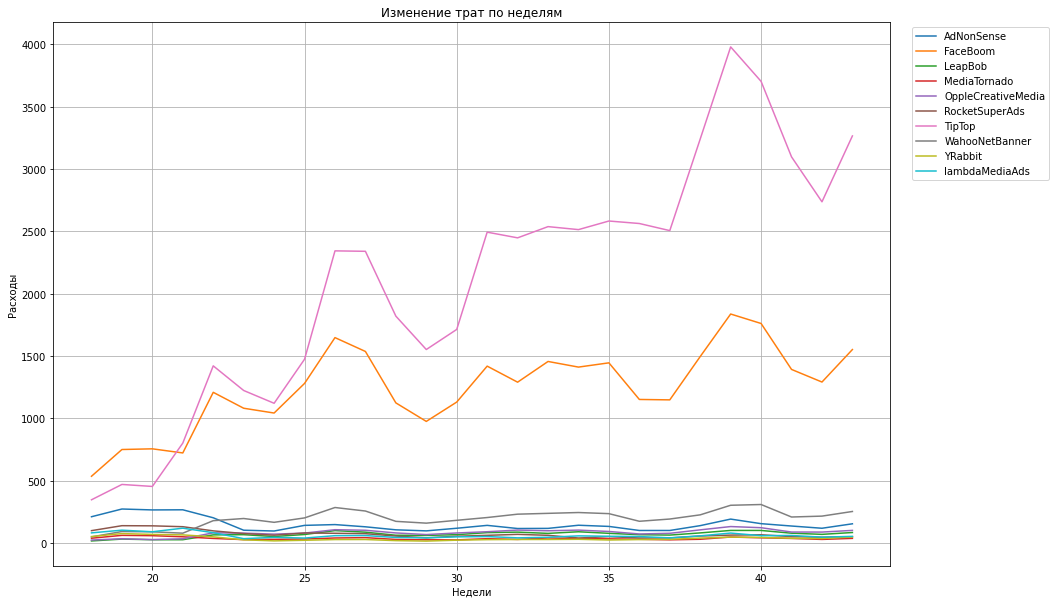

In [38]:
costs.pivot_table(
    index='week',  # недели 
    columns='channel',  # источники переходов
    values='costs',  
    aggfunc='sum',  
).plot(figsize=(15, 10), grid=True)

plt.title('Изменение трат по неделям')
plt.xlabel('Недели')
plt.ylabel('Расходы')
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='best')
plt.show()


В самом начале маркетинговой кампании такие рекламные источники привлечения клиентов как TipTop,
FaceBoom,и lambdaMediaAds получили финансирования больше остальных от 250 до 550., тогда как остальные менее 120. Далее вложения в рекламу особенно росли в TipTop и FaceBoom до 25-й недели и составили порядка 1500. потом вложения в TipTop уверенно вышли на первое место достигнув в своем пике на 39 неделе 4000. Вложения в FaceBoom не превышали 1800, а остальные источники получали в основном менее  300. 

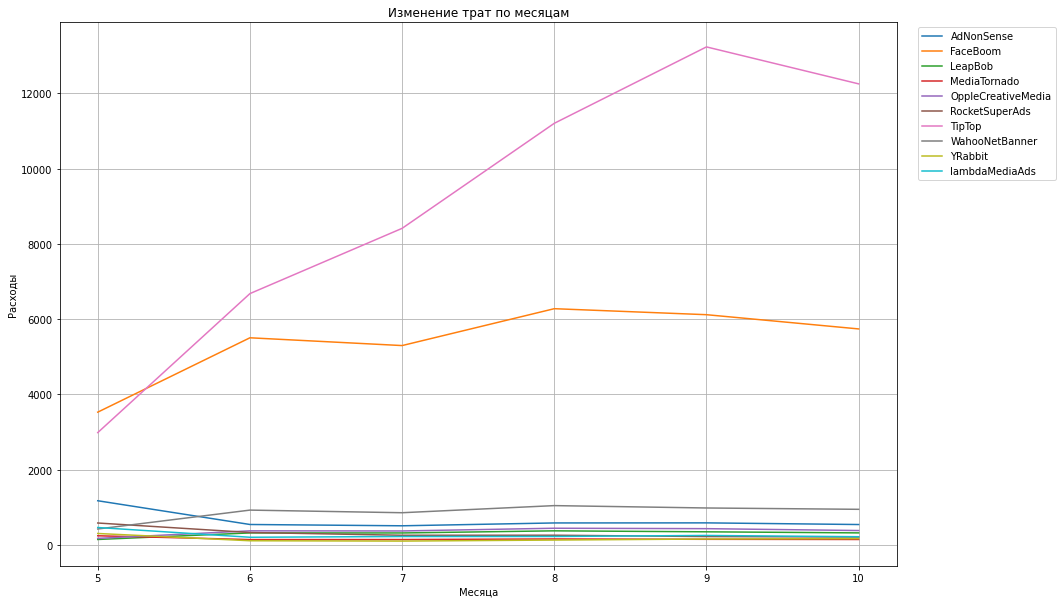

In [39]:
costs.pivot_table(
    index='month',  # даты 
    columns='channel',  # источники переходов
    values='costs',  
    aggfunc='sum',  
).plot(figsize=(15, 10), grid=True)

plt.title('Изменение трат по месяцам')
plt.xlabel('Месяца')
plt.ylabel('Расходы')
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='best')
plt.show()

Динамика изменений расходов по рекламным источникам по месяцам говорит о том, что в начале кампании, в мае, расходы были минимальны, все источники шли примерно на одинаковом уровне до 1000, кроме TipTop и FaceBoom. Расходы на FaceBoom после июня сильно не росли и составляли примерно 6000, а на TipTop росли до сентября, выросли до 13500, и стали уменьшаться до 12100 в октябре.

<a id="4.4"></a>
Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Для этого сгруппируем таблицу с профилями пользователей по каналу привлечения и найдем среднее значение столбца acquisition_cost, полученные значения запишем в столбец САС.

In [40]:
profiles

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
...,...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.500000
150004,999975439887,2019-10-21 00:35:17,organic,PC,UK,2019-10-21,2019-10-01,False,0.000000
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.600000
150006,999979924135,2019-09-28 21:28:09,MediaTornado,PC,United States,2019-09-28,2019-09-01,False,0.205714


In [41]:
cac_user = profiles.groupby('channel').agg({'acquisition_cost': 'mean'}).rename(columns={'acquisition_cost': 'cac'}).sort_values(by = 'cac', ascending = False).reset_index()
cac_user


,channel,cac
0,TipTop,2.799003
1,FaceBoom,1.113286
2,AdNonSense,1.008054
3,lambdaMediaAds,0.724802
4,WahooNetBanner,0.602245
5,RocketSuperAds,0.412095
6,OppleCreativeMedia,0.250000
7,YRabbit,0.218975
8,MediaTornado,0.218717
9,LeapBob,0.210172


Для наглядности построим столбчатую диаграмму распределения стоимости привлечения одного пользователя по источникам. 

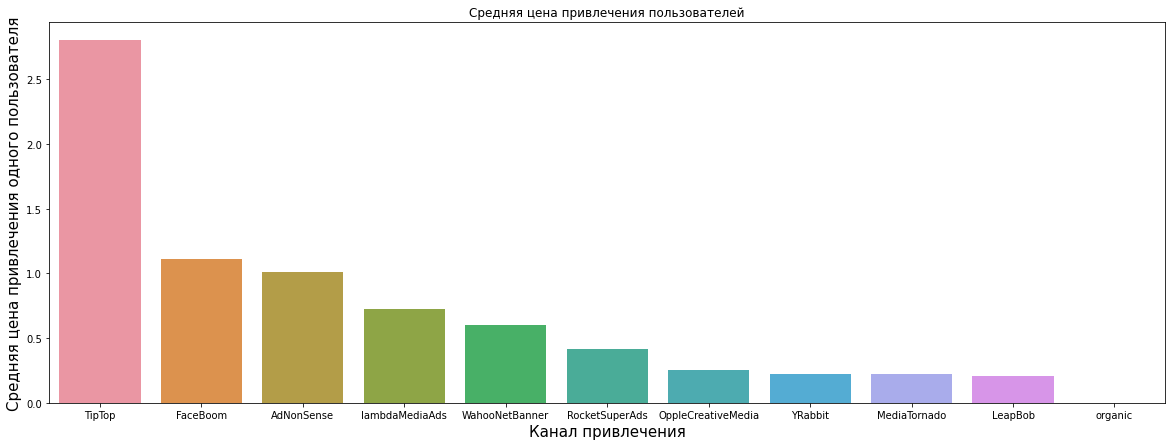

In [42]:
plt.figure(figsize=(20,7))
plt.title('Средняя цена привлечения пользователей')
sns.barplot(data=cac_user, x='channel', y='cac')
plt.xlabel('Канал привлечения', fontsize=15)
plt.ylabel('Средняя цена привлечения одного пользователя', fontsize=15);

На диаграмме нам наглядно видно насколько дороже обошлись пользователи привлеченные с помощью TipTop, на рекламу в котором было потрачено половина бюждета расходов. Пользователи из LeapBob оказались самыми "дешевыми".
	

Рассчитаем средний CAC без разбивки по каналам привлечения

In [43]:
profiles.describe()

,user_id,acquisition_cost
count,1.500080e+05,150008.000000
mean,4.993238e+11,0.703278
std,2.889483e+11,0.954097
min,5.993260e+05,0.000000
25%,2.489249e+11,0.000000
50%,4.977046e+11,0.247500
75%,7.494919e+11,1.108943
max,9.999996e+11,3.715385


Средняя стоимость привлечения одного клиента по всему проекту составила 0.7. Медиана CAC - 0.24. Значит, в данных есть выбросы, периоды с большими тратами, которые влияют на разницу между средним и медианой. Так же на разницу этих показателей вляет наличие органических пользователей, на которых не тратился рекламный бюджет. Максимальная стоимость привлечения пользователя - 3.71.

Проверим CAC всего проекта без учета органических пользователей

In [44]:
cac_total = profiles.query('channel != "organic"').describe()
cac_total
#round(cac_total, 2)

,user_id,acquisition_cost
count,9.356900e+04,93569.000000
mean,4.995116e+11,1.127481
std,2.881600e+11,0.990503
min,5.993260e+05,0.124615
25%,2.506301e+11,0.257143
50%,4.972331e+11,1.080531
75%,7.490889e+11,1.128571
max,9.999799e+11,3.715385


Средняя CAC по всему проекту без учета органических пользователей составила 1.13 . Медиана CAC - 1.08. Отклонения незначительные.

<a id="4.5"></a>
**Итого по данному разделу мы можем сделать следующие выводы:**
Общая сумма расходов на маркетинг приложения 105497. Больше половины из которой была потрачена на привлечение пользователей в источнике TipTop(54751), далее FaceBoom (32445) и меньше всего на YRabbit (944) и MediaTornado (954). С самого начала маркетинговой кампании источники  TipTop и  FaceBoom стали получать гораздо большее финансирование, и после 25 недели явным лидером по финансированию стал TipTop достигнув пика в 38 недели в сентябре. Финансирование  FaceBoom с июня колебалось примерно на одном уровне  1300, остальные источники получали не более 300.  Среднее значение привлечения одного пользователя у  TipTop — 2,8 , долее идет  FaceBoom  с 1,1, самые низкие показатели у YRabbit , MediaTornado, LeapBob  порядка 0,21, не считая, конечно, органических пользователей, на привлечение которых средства не тратились. Хоть у FaceBoom было и значительно меньшее финансирование, чем у  TipTop, но пользователей и платящих пользователей он привлек гораздо больше. 

<a id="roi"></a>
### Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

Для анализа окупаемости рекламы следует исключить органических пользователей, так как на их привлечение поризошло не из рекламных источников. Для этого сделаем срез таблицы с профилями, оставим строки, где пользователи не из канала organic.

In [45]:
profiles = profiles.query('channel != "organic"') #сделаем срез таблицы с профилями, оставим строки, где пользователи не из канала organic.

С учетом горизонта анализа в 14 дней, определим минимальную и максимальную возможную дату анализа

In [46]:
# момент анализа
observation_date = datetime(2019, 11, 1).date()
observation_date

datetime.date(2019, 11, 1)

In [47]:
# горизонт анализа
horizon_days = 14

In [48]:
# минимальная дата привлечения пользователей
min_analysis_date = min_acquisition_date
min_analysis_date

datetime.date(2019, 5, 1)

In [49]:
# максимально возможная дата привлечения с учётом горизонта
max_analysis_date= observation_date - timedelta(days=horizon_days - 1)
max_analysis_date

datetime.date(2019, 10, 19)

<a id="5.1"></a>
Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.

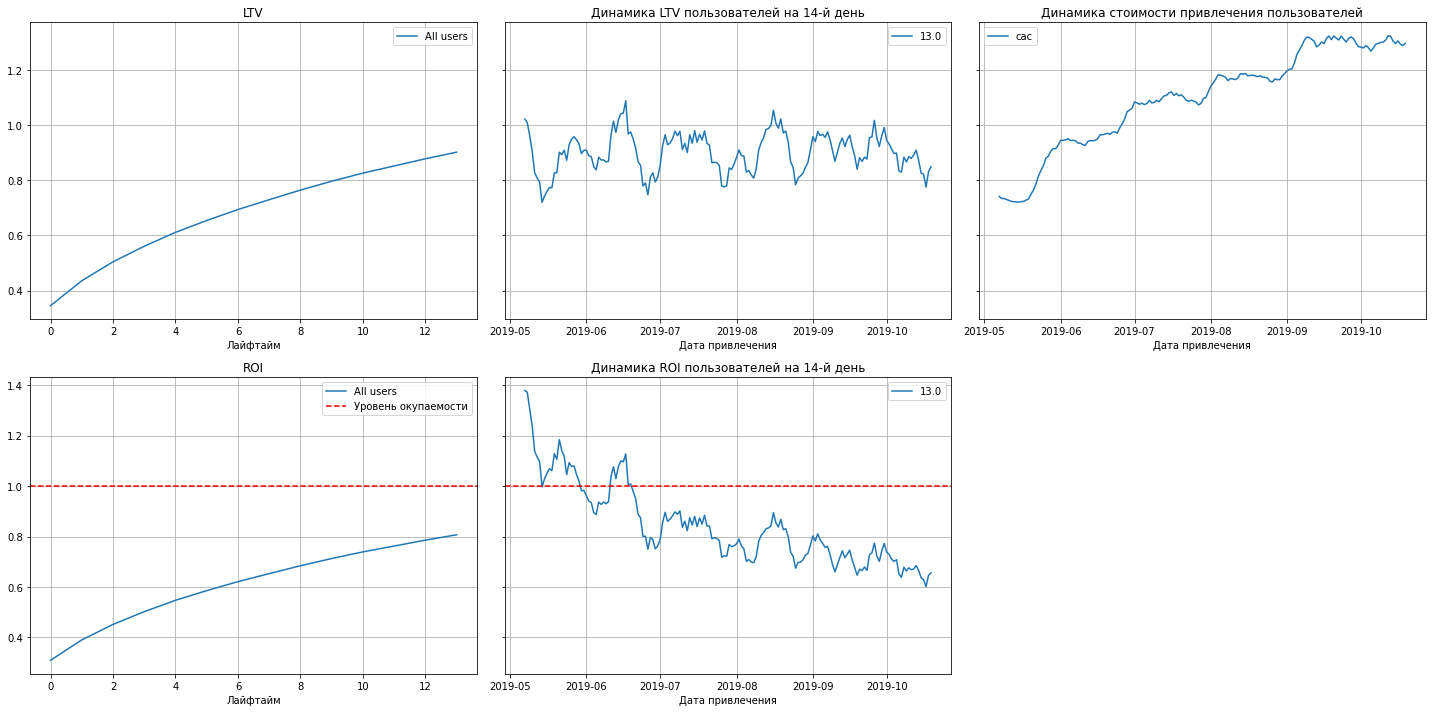

In [50]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Выводы по графикам следующие:
1. Значения ROI (окупаемости инвестиций) в рекламу не достигает уровня окупаемости на протяжении всего лайфтайма и к 14-му дню достигает 80%.
2. Стоимость привлечения пользователей САС постоянно растет.
3. С ростом стоимости привлечения CAC клиентов в июне, окупаемость инвестиций ROI начинает падать за линию окупаемости и после середины июня уже не поднимается выше, а только спускается все ниже-ниже.
4. Показатель LTV довольно-таки стабилен.

<a id="5.2"></a>
Проверим конверсию пользователей и динамику её изменения. Построим и изучим графики конверсии.

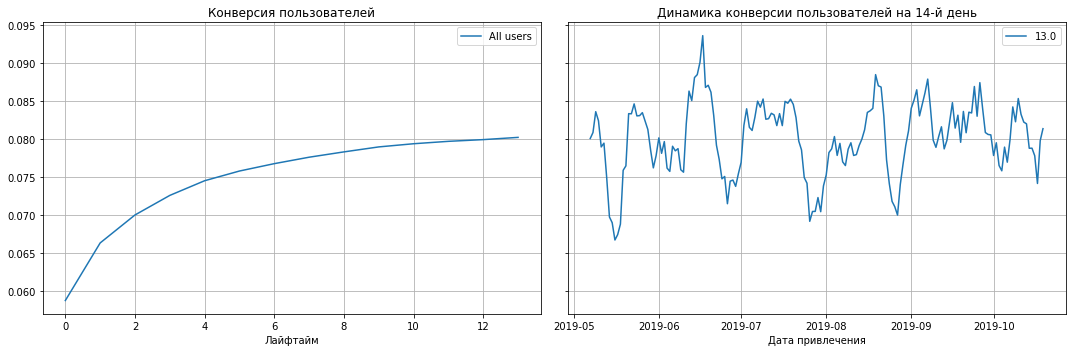

In [51]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Конверсия, то есть переход пользователей в платящих, хорошо растет первые 5 дней лайфтайма, далее тоже наблюдается рост, но он сильно замедляется после 11 дня и вовсе сходит на нет. Конверсия 14-го дня колеблится от 6,7% (середина мая) до 9,3% (середина июня).

<a id="5.3"></a>
Проверим удержание пользователей и динамику его изменения. Построим и изучим графики удержания.

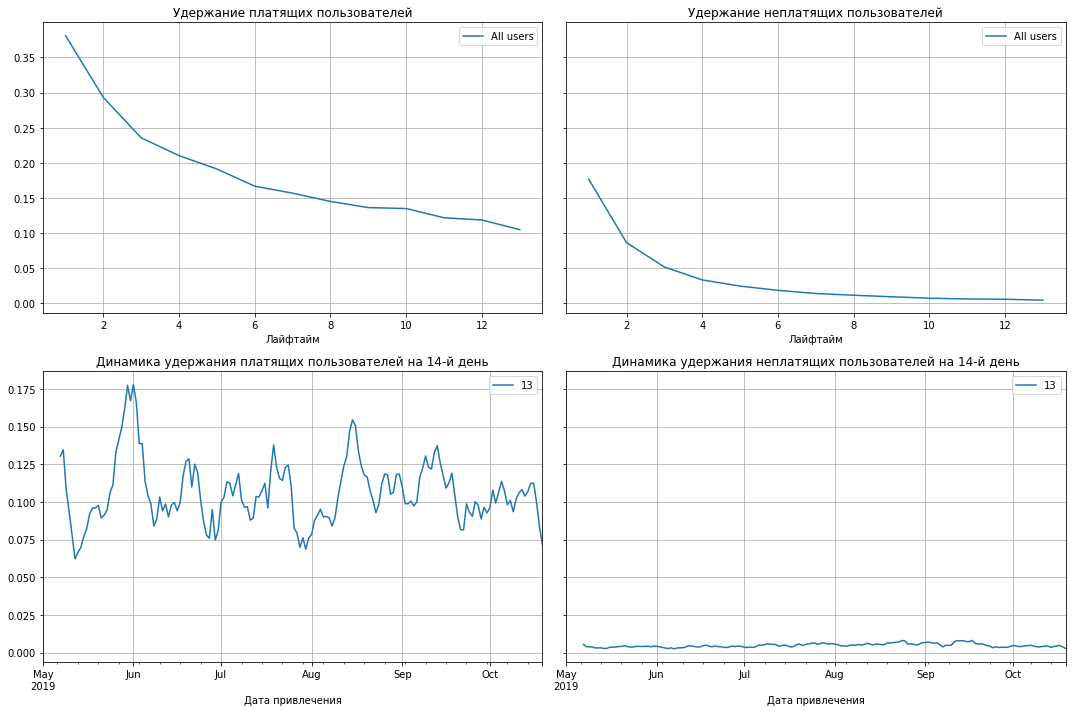

In [52]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание платящих пользователей на первый день жизни составляет примерно 38%, далее с каждым днем идет заметный спад и к концу лайфтайма достигает 10 %. Неплатящие пользователи еще менее активны, после первого дня удержание 18 процентов и далее после 6 показатель стремится к нулю. Удержания платящих в динамике на 14-й день колеблится на уровне от 8 до 13 %, тогда как неплатящие совсем потеряли активность.

<a id="5.4"></a>
Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

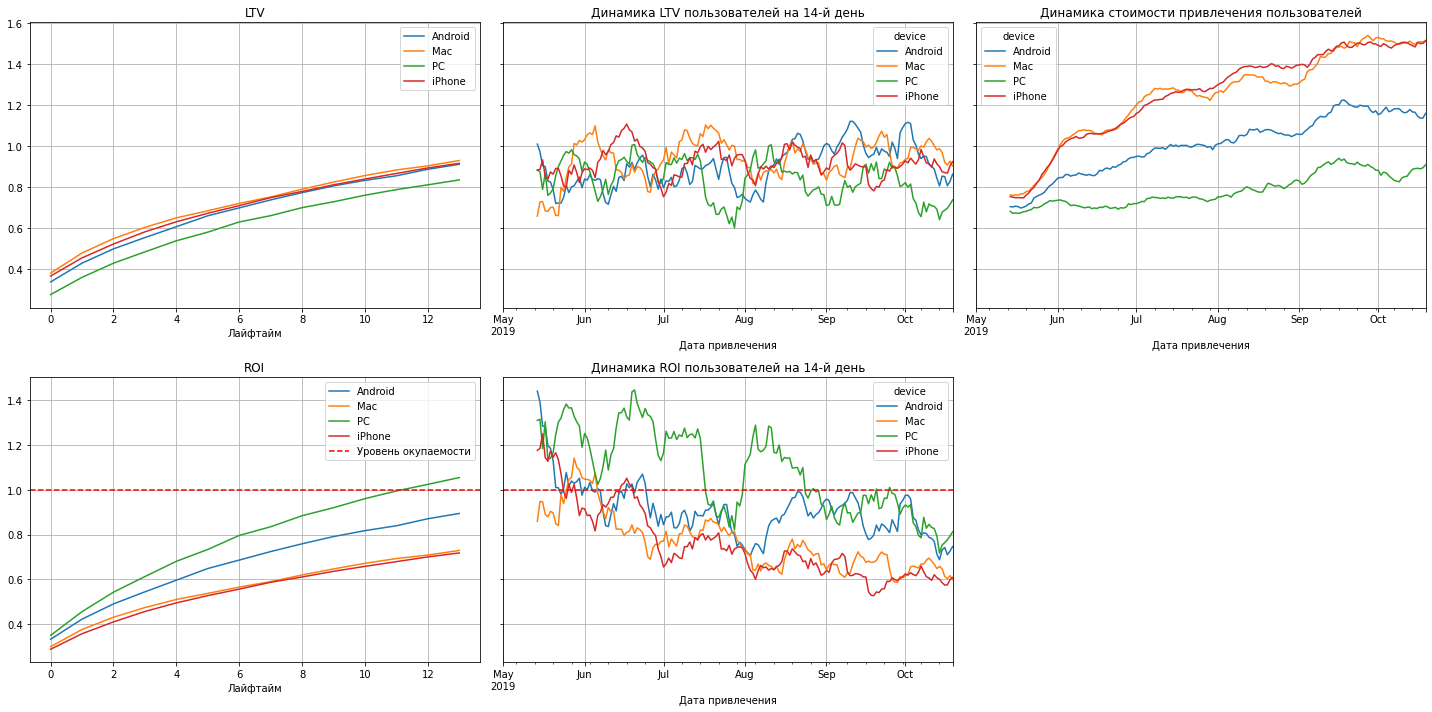

In [53]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Из графиков анализа окупаемости рекламы по устройствам пользователей мы видим, что на привлечение владельцев PC и Android было потрачено меньше средств, и окупаемость владельцев PC, по сравнению с остальными,выше, так, например, на 11 день жизни она пересекает уровень окупаемости, а динамика на 14-й день так же выше уровня окупаемости вплоть до сентября, тогда как владельцы остальных устройств ушли вниз за линию окупаемости уже в июне. Владельцы Mac и Iphone показывают совсем плохие показатели окупаемости. В конце августа перестали окупаться клиенты со всеми устроиствами.

<a id="5.5"></a>
Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

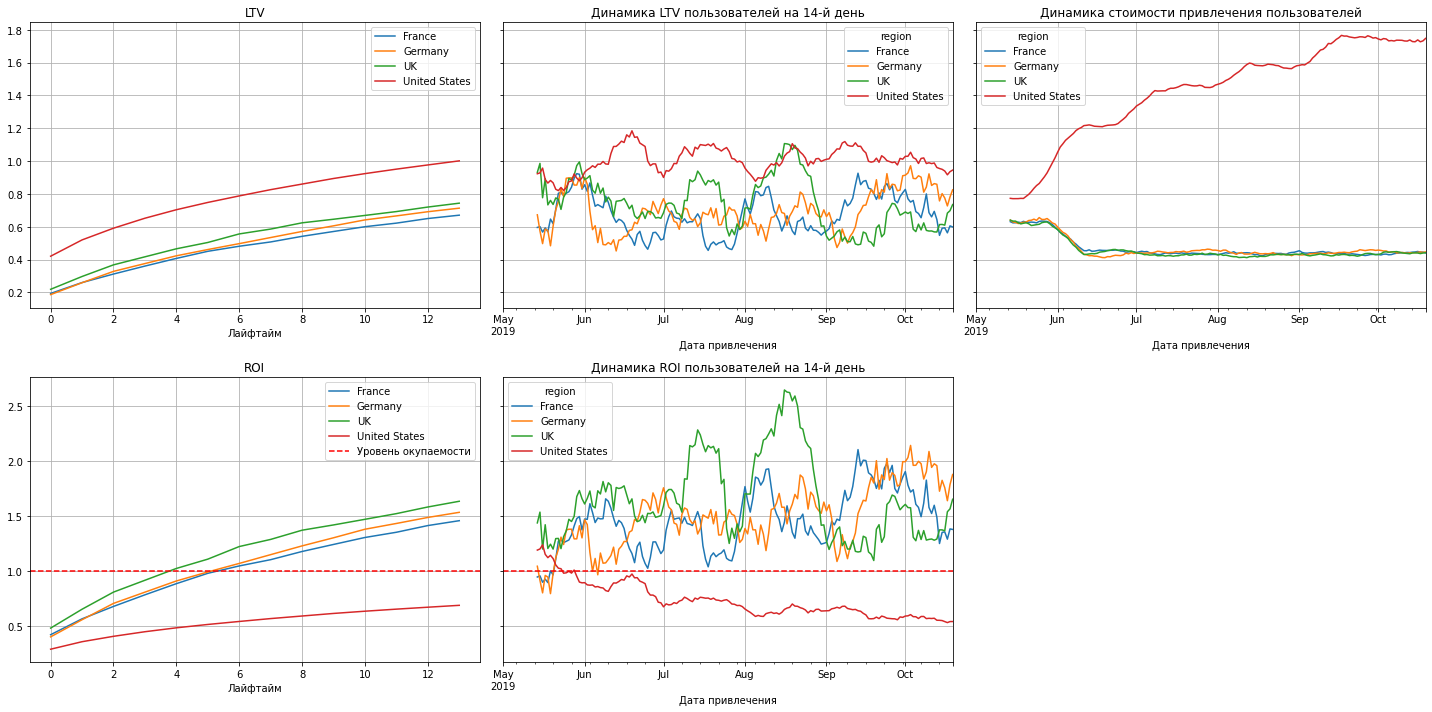

In [54]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Из графиков анализа окупаемости рекламы по регионам пользователей мы видим, что хоть и пользователи из США тратят больше других денег в приложении, но недостаточно много, так как стоимость их привлечения намного выше и постоянно растет и окупаемости далеко до заветного уровня выше единицы. И если в середине мая ROI на конец лайфтайма клиентов из США хоть как-то держалась, то далее идет постоянный спад. Клиенты из Великобритании, пожалуй, более эффективны. Стоимость из привлечения не растет, а показатель ROI после 4 дня жизни пересекает красную линию окупаемости и далее идет на повышение. Германия и Франция имеют примерно одинаковые показатели, однако, после 6 дня жизни Германия, все же начинает немного опережать.

<a id="5.6"></a>
Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

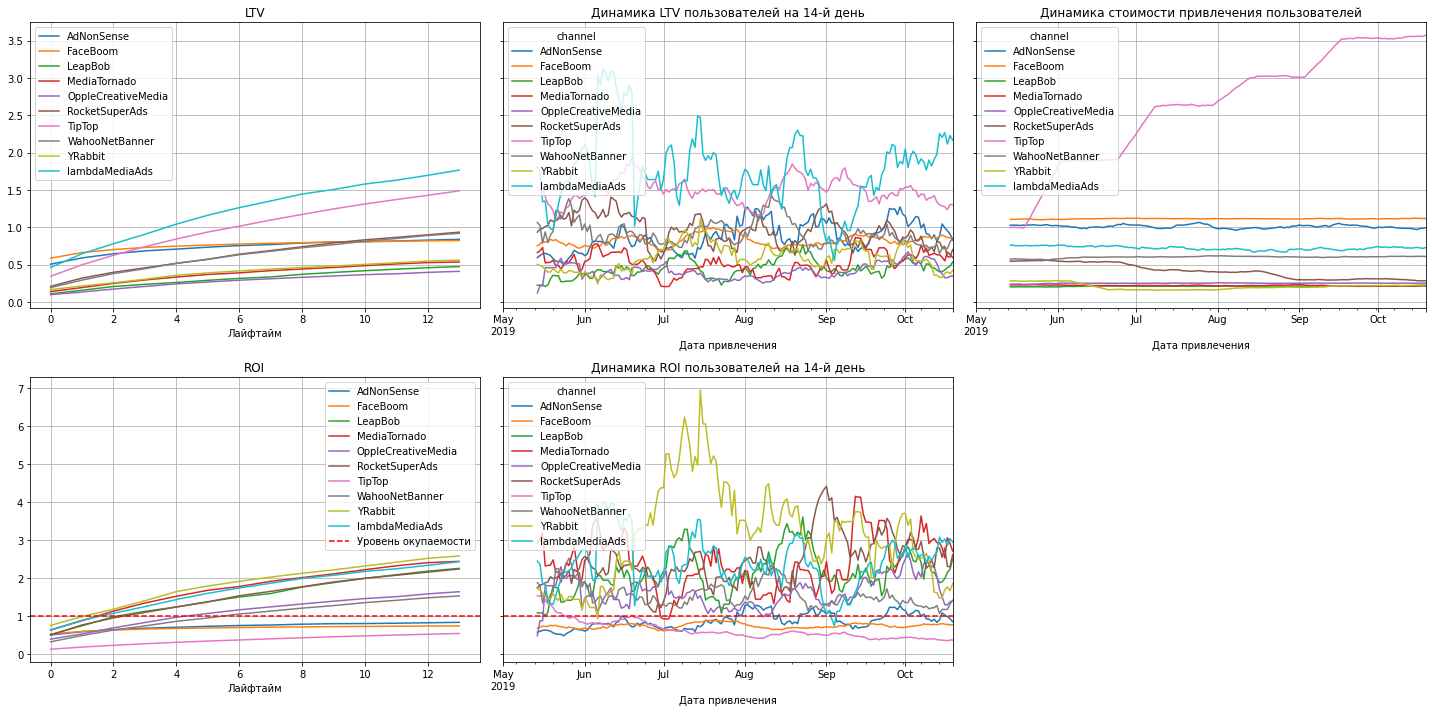

In [55]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

   На графиках анализа окупаемости рекламы по каналам привлечения мы, как и предполагалось на основе ранее проведенного анализа, видим, что вложение половины рекламного бюджета в канал Tip Top не принесло результата, траты на рекламу запредельные, растут с каждым месяцем, по сумме приносимых средств, пользователи, пришедшие из этого канала, на втором месте, а вот показатель окупаемости уверенно держится на самом низком уровне. А вот канал lambdaMediaAds выглядит очень даже прилично. Денег приносит больше остальных, расходы на привлечение средние, окупаемость на нормальном уровне. Также можно выделить канал YRabbit, у него самый высокий показатель ROI, при этом самые низкие вложения и динамики окупаемости на 14-й день в июле-августе показывала самые высокие показатели среди остальных каналов.

<a id="roi_region"></a> Рассмотрим показатели окупаемости отдельно по каждой стране.

<a id="6.1"></a> Наибольшее количество пользователей приложения из США, рассмотрим отдельно этот рынок первым. Для этого сделаем срез таблицы профилей, оставив там только американских пользователей.

In [56]:
profiles_usa = profiles.query('region == "United States"') # срез данных по стране США


Посмотрим на окупаемость с разбивкой по каналам привлечения

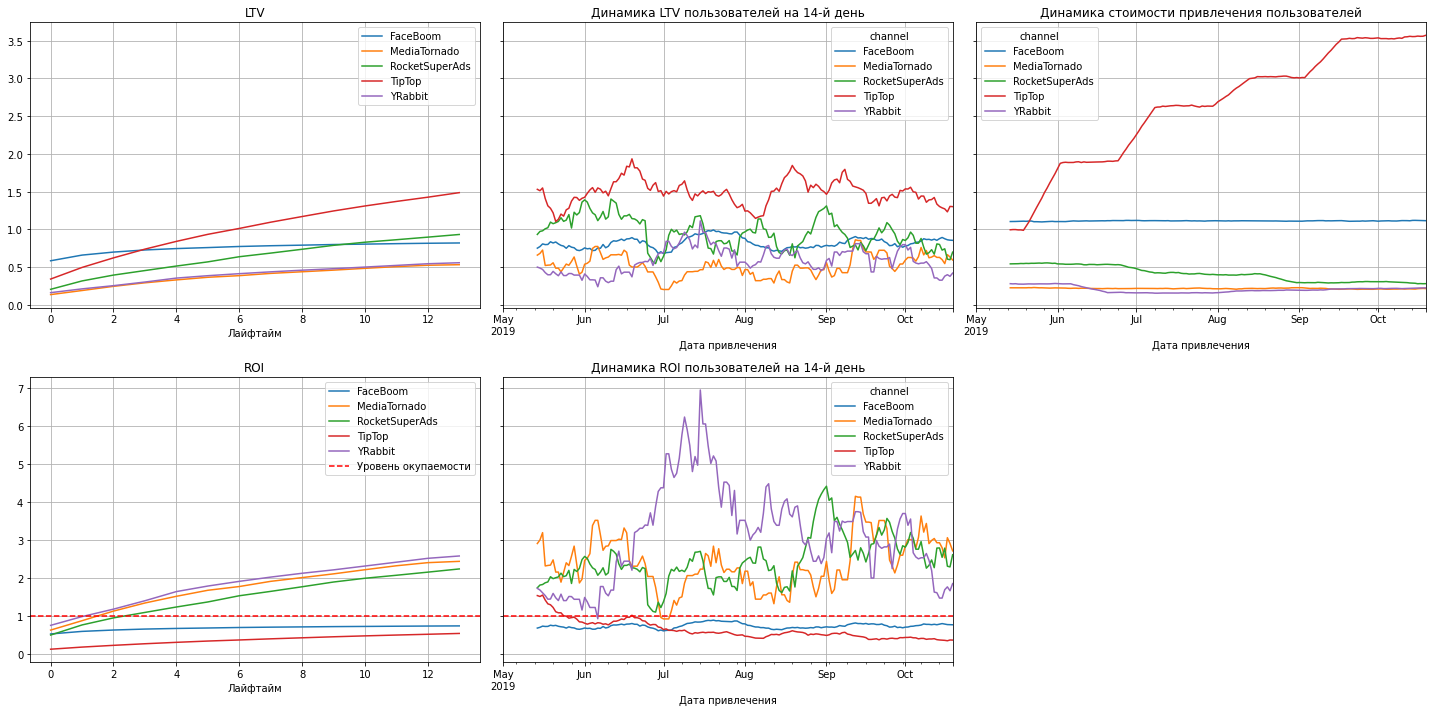

In [57]:
dimensions = ['channel']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_usa, orders, observation_date, horizon_days, dimensions=dimensions)
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

Мы видим, что в США привлечение пользователей шло по 5 каналам, самый высокозатратный из которых - Tiptop, стоимость привлечения по которому с каждым месяцем росла, но не окупилась. FaceBoom не достингул уровня окупаемости, хоть траты на него были средние. А показатели каналов YRabbit, MediaTornado, RocketSuperAds выглядят прилично, траты на них были самые низкие, а уроверь окупаемости они преодолели.

Посмотрим на окупаемость с разбивкой по устройствам

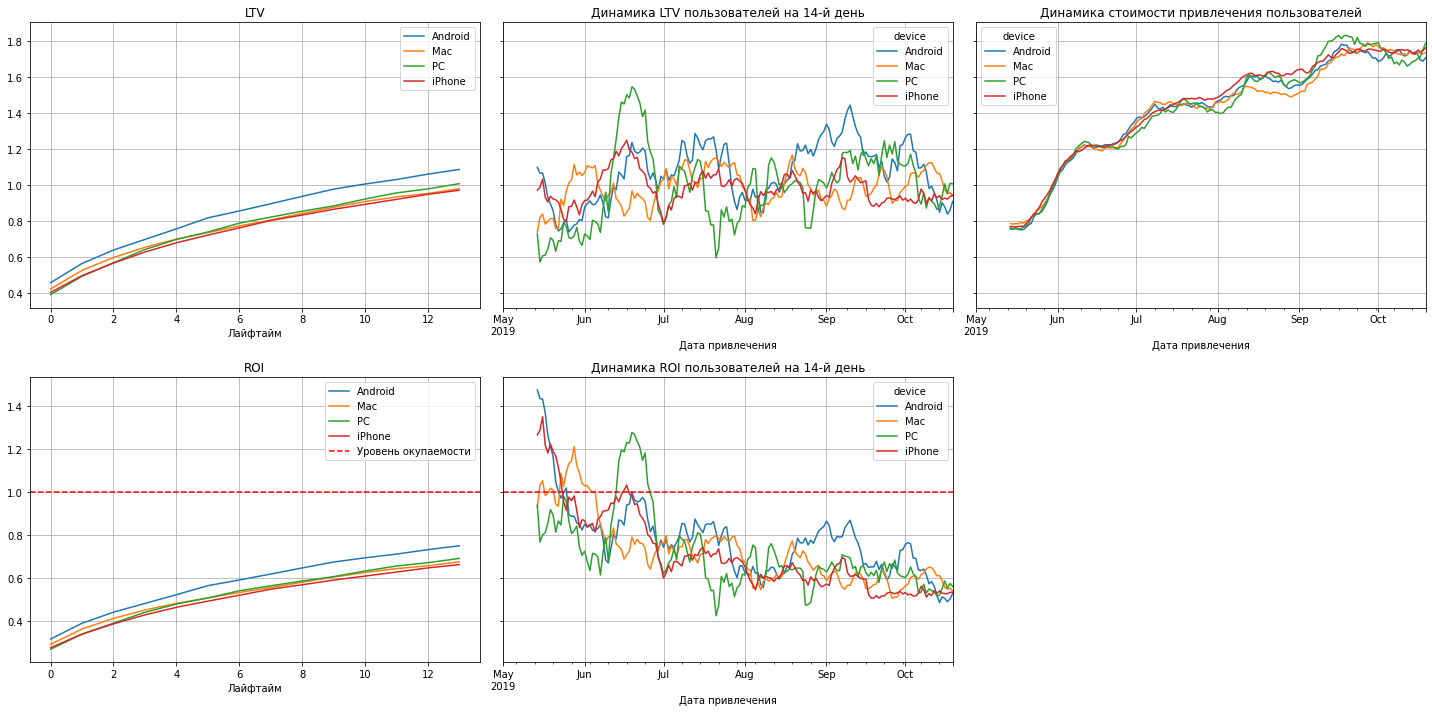

In [58]:
dimensions = ['device']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_usa, orders, observation_date, horizon_days, dimensions=dimensions)
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 


Показатели окупаемости по устройствам в США  для всех устройств выглядят очень схожими, стоимость растет, динамика ROI падает и одно устройство не окупилось.

<a id="6.2"></a> Проанализируем окупаемость во Франции.

In [59]:
profiles_france = profiles.query('region == "France"') # срез данных по стране Франция


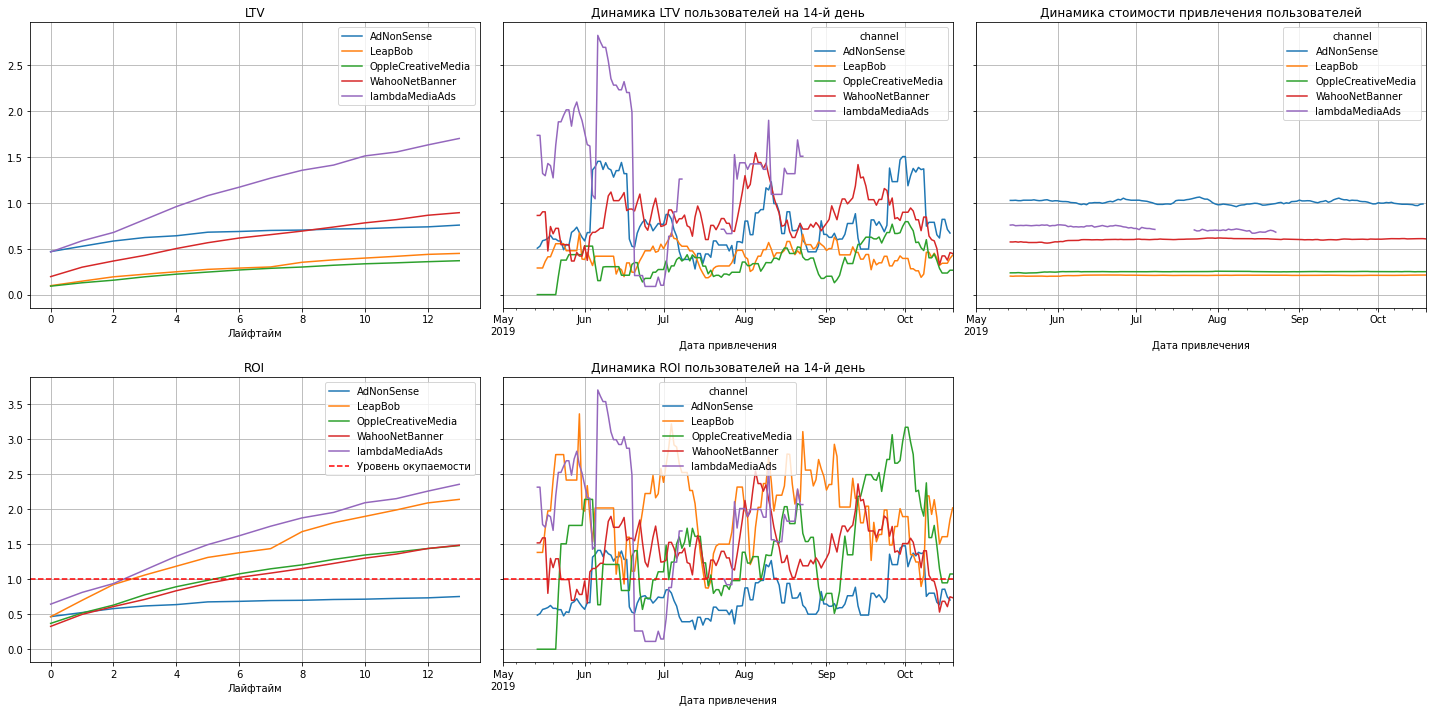

In [60]:
dimensions = ['channel']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_france, orders, observation_date, horizon_days, dimensions=dimensions)
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

Во Франции лидер каналов привлечения - lambdaMediaAds, высокая окупаемость, не самая высокая стоимость привлечения, однако во второй половине августа это канал перестал работать. Канал AdNonSense с высокой CAC совсем не окупился. Хорошо отработал канал LeapBob.

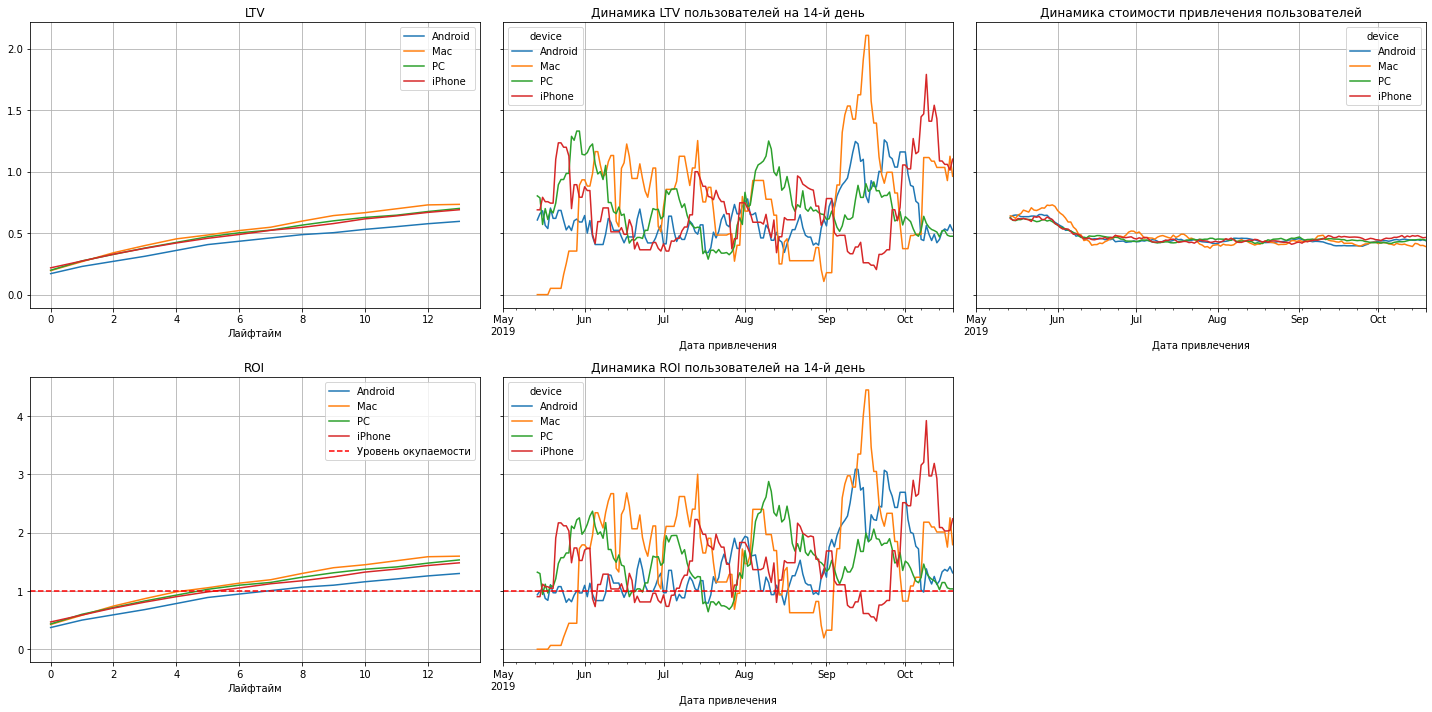

In [61]:
dimensions = ['device']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_france, orders, observation_date, horizon_days, dimensions=dimensions)
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 


По типам устройств во Франции тоже похожая динамика, немного впереди Mac, однако, в отличии от США после 6 дня лайфтайма они вышли на окупаемость.

<a id="6.3"></a> Проанализируем окупаемость в Германии

In [62]:
profiles_germany = profiles.query('region == "Germany"') # срез данных по стране Германия


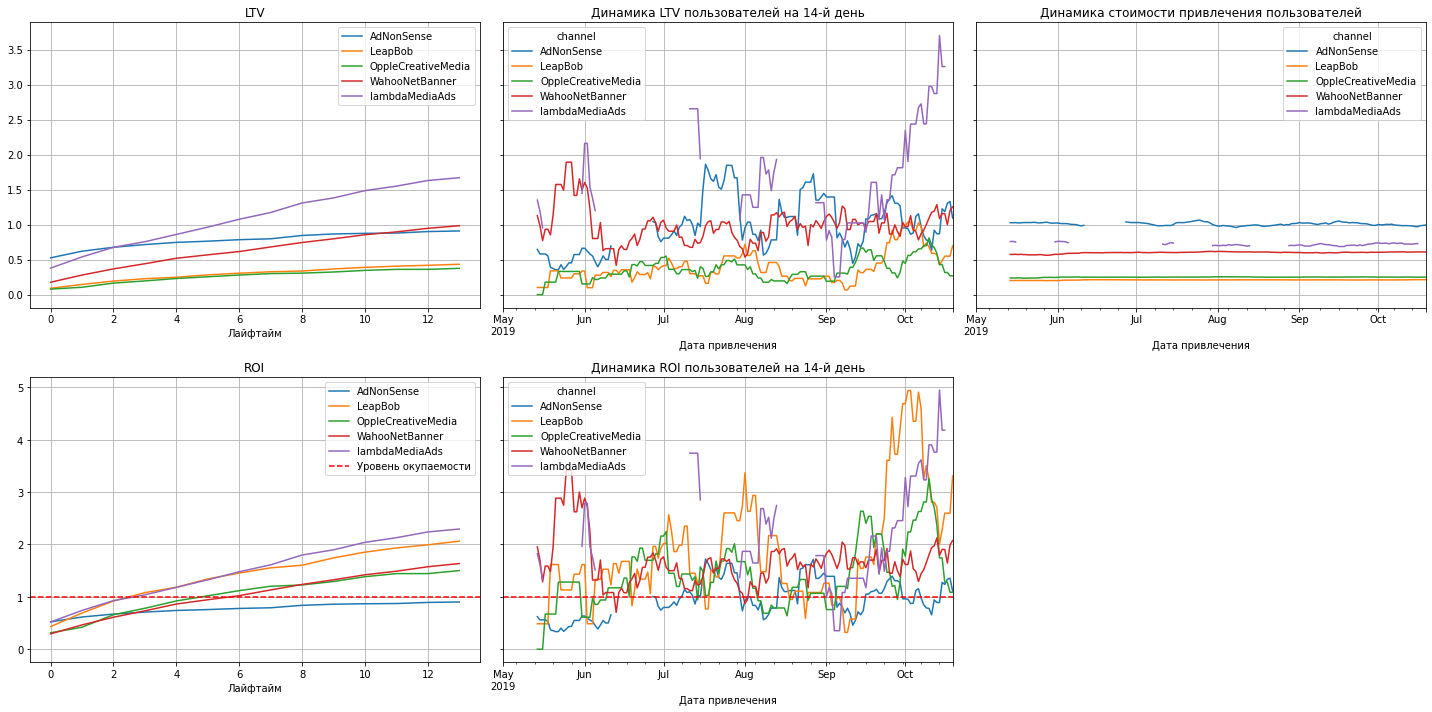

In [63]:
dimensions = ['channel']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_germany, orders, observation_date, horizon_days, dimensions=dimensions)
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

Как и во Франции лидер каналов привлечения - lambdaMediaAds, высокая окупаемость, не самая высокая стоимость привлечения, однако финансирование канала нестабильно. Канал AdNonSense с высокой CAC совсем не окупился. Хорошо отработал канал LeapBob.

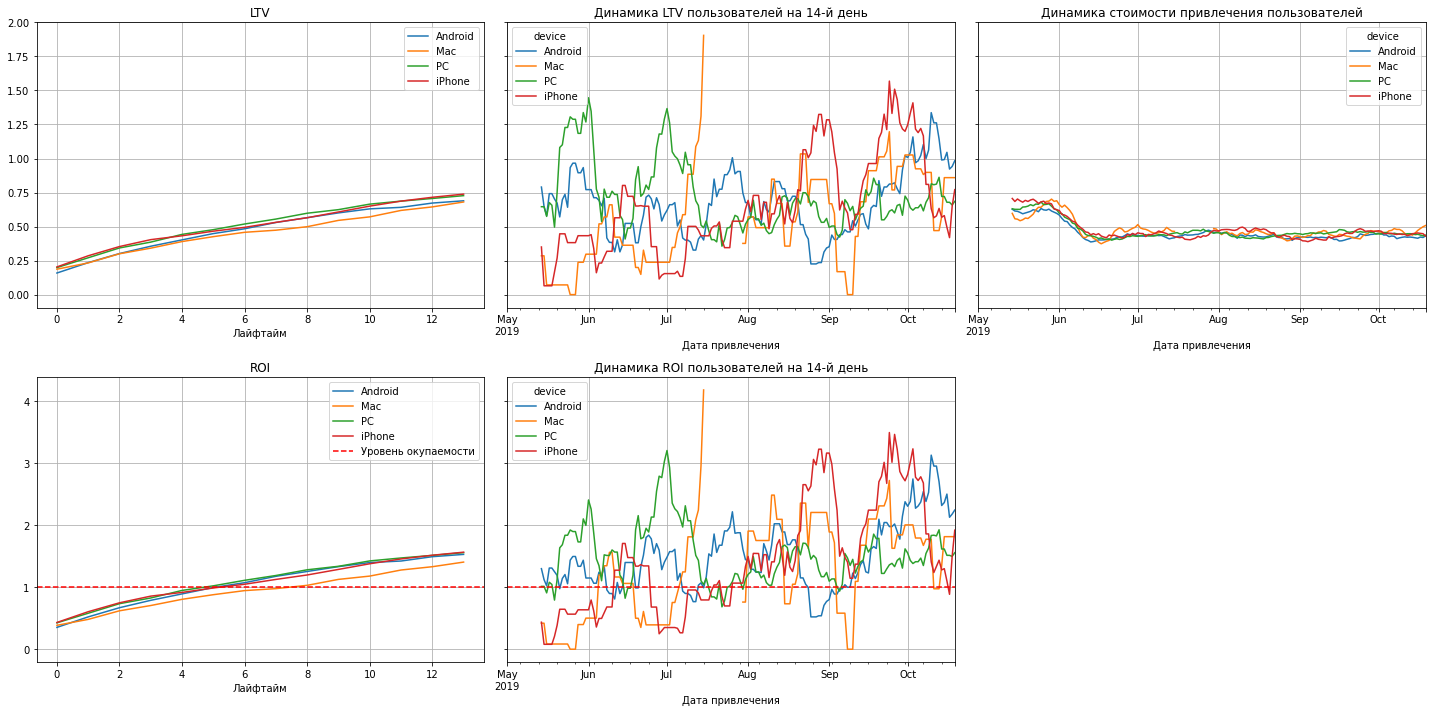

In [64]:
dimensions = ['device']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_germany, orders, observation_date, horizon_days, dimensions=dimensions)
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 


По типам устройств в Германии тоже похожая динамика, после 6 дня лайфтайма они вышли на окупаемость.

<a id="6.4"></a> Проанализируем окупаемость в Великобритании.

In [65]:
profiles_uk = profiles.query('region == "UK"') # срез данных по стране Великобритания


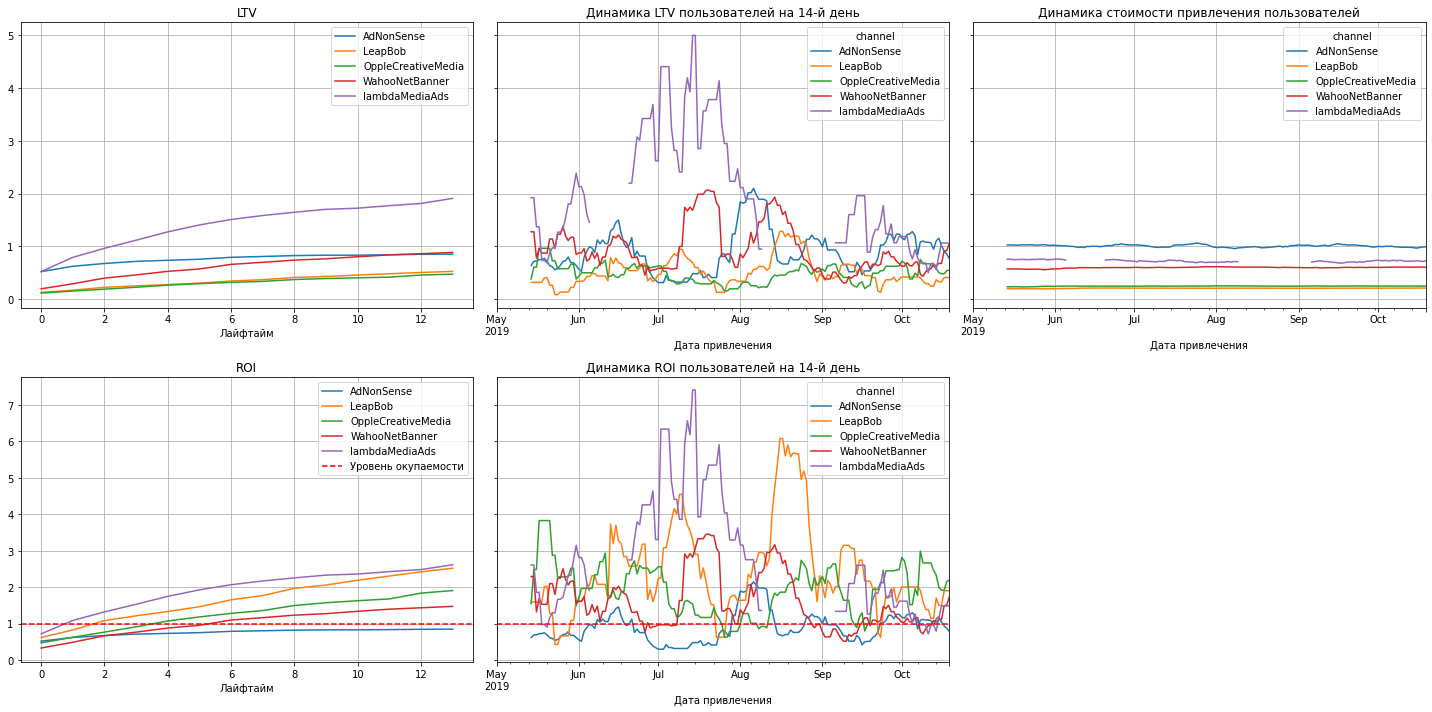

In [66]:
dimensions = ['channel']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_uk, orders, observation_date, horizon_days, dimensions=dimensions)
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

Опять в лидерах канал lambdaMediaAds, высокая окупаемость, не самая высокая стоимость привлечения, однако финансирование канала нестабильно. Канал AdNonSense с высокой CAC совсем не окупился. Хорошо отработал канал LeapBob.

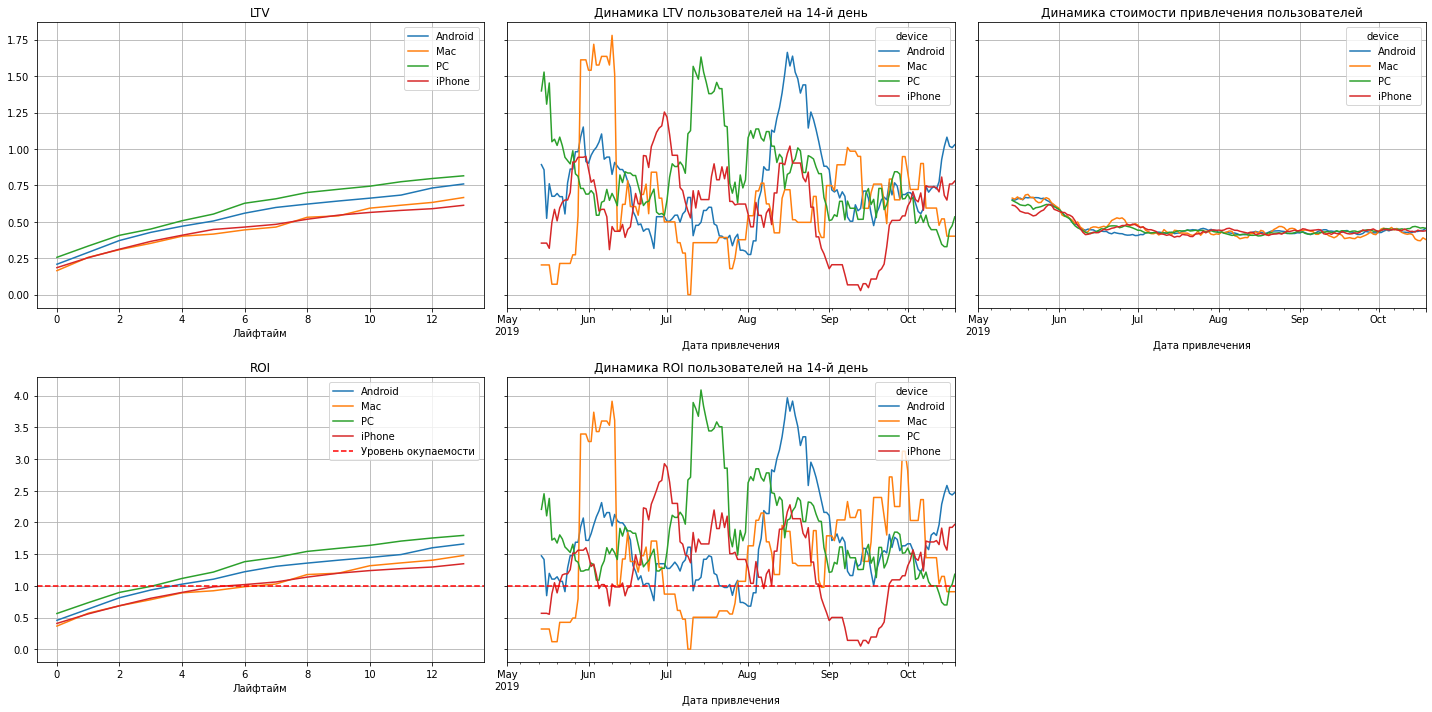

In [67]:
dimensions = ['device']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_uk, orders, observation_date, horizon_days, dimensions=dimensions)
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 


По типам устройств в Великобритании тоже похожая динамика, после 6 дня лайфтайма они вышли на окупаемость, PC немного впереди.

<a id="6.5"></a> По результатм анализа окупаемости рекламной кампании по отдельным странам, мы видим, что было задействовано по 5 каналов привлечения в каждой стране. Во Франции, Германии, Великобритании были задействованы одни и те же каналы привлечения. Самые действенные из которых оказались - lambdaMediaAds и LeapBob, а канал AdNonSense не окупился.
В США были задействованы свои каналы, самый высокозатратный из которых - Tiptop, стоимость привлечения по которому с каждым месяцем росла, но не окупилась. FaceBoom не достингул уровня окупаемости, хоть траты на него были средние. А показатели каналов YRabbit, MediaTornado, RocketSuperAds выглядят прилично, траты на них были самые низкие, а уроверь окупаемости они преодолели.
По типам устройств в США  по показателям окупаемости лидирует Android, во Франции - Mac, в Великобритани PC, в Германии нет лидера.

### Напишите выводы

- Выделите причины неэффективности привлечения пользователей.
- Сформулируйте рекомендации для отдела маркетинга.

<a id="conclusion"></a>
  Несмотря на огромные вложения в рекламу, последние несколько месяцев компания- разработчик развлекательного приложения терпит убытки. Нашей задачей бало разобраться в причинах и помочь компании выйти в плюс.
Для целей анализа бизнес-показателей развлекательного приложения Procrastinate Pro+ мы использовали данные о визитах, заказах и рекламных расходах компании.
* На этапе предобработки мы изучили данные, выяснили, что в данных нет пропусков и дубликатов, изменили типы данных и названия столбцов, где это требовалось.
В бизнес-плане разработчика заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. На календаре 1 ноября 2019 года, горизонт анализа 14 дней, следовательно мы имеем максимальную дату привлечения пользователей - 19 октября 2019 года, а минимальная - 1 мая 2019 года.
* На первом этапе анализа мы выяснили, что  больше всего пользователей приложения из США - 100002, 6.9 % из которых - платящие. Далее по количеству пользоватеелй идет Великобритания - 17575 с 4% платящих пользователей, Франция - 17450 с 3,8 % платящих пользователей и последняя Германия - 14981 с 4,1% платящих пользователей и этот показатель у нее вышеЮ чем у Великобритании и Франции, но ненамного.
Больше всего пользователей пользуется приложением на iPhone	- 54479, а доля платящих составляет 6.2%. Далее по популярности идет Android - 35032, доля платящих 5.8%, следом PC	- 30455 и 5 % и тут же Mac с небольшой разницей в количестве пользователей - 30042, но с самым высоким процентом платящих клиентов - 6,4 %. 
Больше всего пользователей "органических", те ,которые не пришли с каких-либо рекламных источников - 56439. Лидеры рекламных источников по наибольшему количеству привлеченных пользователей -FaceBoom и TipTop (29144 и 19561 соответственно). Наименьшая доля платящих пользователей у тех, кто не пришел с рекламных источников - всего 2%, а наибольшая у FaceBoom 12%, AdNonSense 11%.
* Для целей дальнейшего анализа расходов на маргетинг и окупаемость мы исключили из данных органических пользователей, так как для их привлечения не тратились денежные средства. 
Общая сумма расходов на маркетинг составила 105497 у.е., около половины которой, было потрачено на рекламу в TipTop(54751.30), далее FaceBoom (32445.60) и меньше всего на YRabbit (944.22). При анализе стоимости привлечения пользователей по каналам привлечения, выяснили, что среднее значение привлечения одного пользователя у TipTop — 2,8 , далее идет FaceBoom с 1,1, самые низкие показатели у YRabbit , MediaTornado, LeapBob порядка 0,21, не считая, конечно, органических пользователей, на привлечение которых средства не тратились. 
* Далее мы поработали над анализом окупаемости рекламы. Выяснили, что значения ROI (окупаемости инвестиций) в рекламу не достигает уровня окупаемости на протяжении всего лайфтайма и к 14-му дню достигает 80%. Стоимость привлечение пользователей САС постоянно растет. С ростом стоимости привлечения CAC клиентов в июне, окупаемость инвестиций ROI начинает падать за линию окупаемости и после середины июня уже не поднимается выше, а только спускается все ниже-ниже. Показатель LTV довольно-таки стабилен, что говорит о том, что качества пользователей не ухудшались. 
Конверсия, то есть переход пользователей в платящих, хорошо растет первые 5 дней лайфтайма, далее тоже наблюдается рост, но он сильно замедляетсяа после 11 дня и вовсе сходит на нет. конверсия 14-го дня колеблится от 6,7% (середина мая) до 9,3% (середина июня). Удержание платящих пользователей на первый день жизни составляет примерно 38%, далее с каждым днем идет заметный спад и к концу лайфтайма достигает 10 %. Неплатящие пользователи еще менее активны, после первого дня удержание 18 процентов и далее после 6 показатель стремится к нулю. Удержания платящих в динамике на 14-й день колеблится на уровне от 8 до 13 %, тогда как неплатящие совсем потеряли активность.
При анализе окупаемости рекламы по устройствам пользователей мы увидели, что на привлечение владельцев PC и Android было потрачено меньше средств, и окупаемость владельцев PC, по сравнению с остальными,выше. Владельцы Mac и Iphone показывают совсем плохие показатели окупаемости. В конце августа перестали окупаться клиенты со всеми устроиствами.
Анализ окупаемости рекламы по регионам пользователей показал, что хоть и пользователи из США тратят больше других денег в приложении, но недостаточно много, так как стоимость их привлечения намного выше и постоянно растет и окупаемости далеко до заветного уровня выше единицы. Клиенты из Великобритании, пожалуй, более эффективны. Стоимость из привлечения не растет, а показатель ROI после 4 дня жизни пересекает красную линию окупаемости и далее идет на повышение. Германия и Франция имеют примерно одинаковые показатели, однако, после 6 дня жизниь Германия, все же начинает немного опережать.
Вложение половины рекламного бюджета в канал Tip Top не принесло результата, траты на рекламу запредельные, растут с каждым месяцем, по сумме приносимых средст пользователи, пришедшие из этого канала на втором месте, а вот показатель окупаемости уверенно держится на самом низком уровне. А вот канал lambdaMediaAds выглядит очень даже прилично. Денег приносит больше остальных, расходы на привлечение средние, окупаемость на нормальном уровне. Также можно выделить канал YRabbit, у него самый высокий показатель ROI, при этом самые низкие вложения и динамики окупаемости на 14-й день в июле-августе показывала самые высокие показатели среди остальных каналов.
* Проанализировав окупаемость рекламной кампании по каждой стране мы выяснили, что было задействовано по 5 каналов привлечения. Во Франции, Германии, Великобритании были задействованы одни и те же каналы привлечения. Самые действенные из которых оказались - lambdaMediaAds и LeapBob, а канал AdNonSense не окупился. В США были задействованы свои каналы, самый высокозатратный из которых - Tiptop, стоимость привлечения по которому с каждым месяцем росла, но не окупилась. FaceBoom не достингул уровня окупаемости, хоть траты на него были средние. А показатели каналов YRabbit, MediaTornado, RocketSuperAds выглядят прилично, траты на них были самые низкие, а уроверь окупаемости они преодолели. По типам устройств в США по показателям окупаемости лидирует Android, во Франции - Mac, в Великобритани PC, в Германии нет лидера.

Итак, на основе проведенного исследования можно сделать следующий ***общий вывод***:

***Причины неэффективности привлечения пользователей следующие:***

1. Слишком большие, не оправданные траты на рекламу для привлечения пользователей из США - это, пожалуй, решающий момент в убыточности рекламной кампании.  К тому же и удержание платящих пользователей из США оказалось хуже остальных.
2. Так же самое крупное  вложение в канал привлечения клиентов - Tip Top, осталось не оправданным. 
3. Низкое удержание пользователей, даже платящих.

***Рекомендации для отдела маркетинга:***

1. Стоит поискать новые каналы привлечения клиентов, а так же обратить особое внимание на такие каналы как lambdaMediaAds и YRabbit, вложения в которые принесло результаты.
2. Мы выяснили, что владельцы ПК удерживаются лучше всего, и единственные из всех устройств окупаются к концу второй недели -стоит подумать над способами привлечения таких клиентов, например, произвести рассылку уведомлений по e-mail, на мой взгяд это не крупнозатратная еффективная мера. Так же стоит обратить внимание на привлечение пользователей, использующих Андроид.
3. Стоит пересмотреть распределение затрат на рекламу по странам. Лучше всего окупается Великобритания и Германия. Стоит обратить внимание на эту аудиторию. 
4. Для повышения уровня удержания клиентов можно разработать привлекательную программу лояльности. Большое значение имеет сильная техническая поддержка: нужно показать клиенту, что вы всегда на связи и всегда готовы помочь.  Так же подумать над обратной связью от клиентов, скорее всего внедрение данной опции поможет разобраться в недочетах приложения и поможет улучшить качество услуг, избежать оттока покупателей.
